In [2]:
import chess

In [28]:
class Checkers:
    def __init__(self):
        self.size = 8
        self.turn = chess.BLACK
        self.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/8/8/P1P1P1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
    
    def isCellEmpty(self, i):
        return self.board.piece_at(i) is None
            
    def ifIsPositionWithinBoundary(self, x, y):
        return x>=0 and y>=0 and x<self.size and y<self.size
    
    def bottomRight(self, pos):
        x, y = pos//self.size-1, pos%self.size+1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
    
    def bottomLeft(self, pos):
        x, y = pos//self.size-1, pos%self.size-1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
    
    def topRight(self, pos):
        x, y = pos//self.size+1, pos%self.size+1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None 
        
    def topLeft(self, pos):
        x, y = pos//self.size+1, pos%self.size-1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) else None
    
    def pieceAtPosition(self,pos):
        return self.board.piece_at(pos)
        
    def validNeighbors(self,pos):
        tl = self.topLeft(pos)
        tr = self.topRight(pos)
        bl = self.bottomLeft(pos)
        br = self.bottomRight(pos)
        valid = []
        piece = self.pieceAtPosition(pos)
        if piece is None:
            raise Exception("Sorry, no piece present at position" + str(pos))
        
        if piece.piece_type == chess.PAWN and piece.color == chess.WHITE:
            if tl is not None:
                valid.append(tl)
            if tr is not None:
                valid.append(tr)
                
        elif piece.piece_type == chess.PAWN and piece.color == chess.BLACK:
            if bl is not None:
                valid.append(bl)
            if br is not None:
                valid.append(br)
                
        else:
            if tl is not None:
                valid.append(tl)
            if tr is not None:
                valid.append(tr)
            if bl is not None:
                valid.append(bl)
            if br is not None:
                valid.append(br)
                
        return valid
    
        
    def getOppColorPieces(self, neighbors, color):
        return [neighbor for neighbor in neighbors if self.pieceAtPosition(neighbor) is not None \
                               and self.pieceAtPosition(neighbor).color is not color]
    
    def validJumps(self, pos1, pos2):
        x1, y1 = pos1//self.size, pos1%self.size
        x2, y2 = pos2//self.size, pos2%self.size
        x, y = 2 *  x2 - x1, 2 * y2 - y1
        return x*self.size+y if self.ifIsPositionWithinBoundary(x,y) and self.isCellEmpty(x*self.size+y) else None
    
    def getFirstJumpsForPos(self, pos):
        jumps = []
        oppColorPositons = self.getOppColorPieces(self.validNeighbors(pos), self.board.piece_at(pos).color)
        for positions in oppColorPositons:
            if self.validJumps(pos,positions) is not None:
                jumps.append(self.validJumps(pos,positions))
        return jumps
            
    def getAllFirstJumps(self, turn):
        firstJumps = {}
        allPiecesPosition = [position for position in self.board.piece_map().keys() if self.board.piece_at(position).color == turn]
        for position in allPiecesPosition:
            firstJumpPos = self.getFirstJumpsForPos(position)
            if len(firstJumpPos) is not 0:
                firstJumps[position] = firstJumpPos
        return firstJumps
    

    '''
      5: [[6], , ]
    '''
    def getCaptureMovesForPos(self, pos):

        paths = []

        for nextPos in self.getFirstJumpsForPos(pos):
          pieceRemoved = self.capturePiece(pos, nextPos)
          self.makeMove(pos, nextPos)

          remainingPaths = self.getCaptureMovesForPos(nextPos)
          for remainingPath in remainingPaths:
            remainingPath.push_front(pos)
            paths.append(remainingPath)

          self.unCapturePiece(pieceRemoved)
          self.unMove(pos, nextPos)
        
        return paths
        


            
    def capturePiece(self, fromPos, toPos):
      x1, y1 = fromPos//self.size, fromPos%self.size
      x2, y2 = toPos//self.size, toPos%self.size

      # add checks for valid jump
      # add checks for piece in between

      x, y = (x1 + x2) // 2, (y1 + y2) // 2

      return self.board.remove_piece_at(x * self.size + y)  
                
    def unCapturePiece(self, fromPos, toPos, piece):
      x1, y1 = fromPos//self.size, fromPos%self.size
      x2, y2 = toPos//self.size, toPos%self.size

      # add checks for valid jump
      # add checks for piece in between

      x, y = (x1 + x2) // 2, (y1 + y2) // 2

      self.board.set_piece_at(x * self.size + y, piece)  


    
    def getRemainingMovesForPos(self, pos):
        return [positions for positions in self.validNeighbors(pos) if self.isCellEmpty(positions)]
    
    
    def getAllRemainingMoves(self, turn):
        moves = {}
        allPiecesPosition = [position for position in self.board.piece_map().keys() if self.board.piece_at(position).color == turn]
        for position in allPiecesPosition:
            moveForPos = self.getRemainingMovesForPos(position)
            if len(moveForPos) is not 0:
                moves[position] = moveForPos
        return moves
    
    def isValidMove(self, i, j):
      # complete
        return True
    
    def isCaptureMove(self, i, j):
      return abs((j % self.size) - (i % self.size)) == 2

    def makeMove(self, i, j):
        if self.isValidMove(i, j):
            piece = self.board.remove_piece_at(i)
            self.board.set_piece_at(j, piece)
        
        if self.isCaptureMove(i, j):
          return self.capturePiece(i, j)
        
        else:
          return None

    def unMove(self, i, j, pieceToPlace):
      piece = self.board.remove_piece_at(j)
      self.board.set_piece_at(i, piece)

      if pieceToPlace is not None:
        self.unCapturePiece(i, j, pieceToPlace)    
    
#     def minimax()
        

In [33]:
import unittest
import chess
class UnitTest(unittest.TestCase):
    
    def setUp(self):
        self.checkers = Checkers()
        
    
    def test_initialize_board_correct(self):
        expected_board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/8/8/P1P1P1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual(expected_board, self.checkers.board)
    
    def test_initialize_board_incorrect(self):
        expected_board = chess.Board("p1p1ppp1/1p1p1p1p/p1p1p1p1/8/8/1P1P1P1P/P1P1P1P1/1P1P1P1P b KQkq - 0 4")
        self.assertNotEqual(expected_board, self.checkers.board)
    
    def test_isEmpty(self):
        self.assertTrue(self.checkers.isCellEmpty(27))
        self.assertFalse(self.checkers.isCellEmpty(9))
    
    def test_isValidBottomRight(self):
        self.assertEqual(self.checkers.bottomRight(9),2)
        
    def test_isValidBottomLeft(self):
        self.assertEqual(self.checkers.bottomLeft(9),0)
        
    def test_isValidTopRight(self):
        self.assertEqual(self.checkers.topRight(9),18)
        
    def test_isValidTopLeft(self):
        self.assertEqual(self.checkers.topLeft(9),16)
    
    def test_isInvalidBottomRight(self):
        self.assertEqual(self.checkers.bottomRight(7),None)
        
    def test_isInvalidBottomLeft(self):
        self.assertEqual(self.checkers.bottomLeft(7),None)
        
    def test_isInvalidTopRight(self):
        self.assertEqual(self.checkers.topRight(58),None)
        
    def test_isInvalidTopLeft(self):
        self.assertEqual(self.checkers.topLeft(58),None)
        
    def test_isValidPositionPiece(self):
        piece = self.checkers.pieceAtPosition(0)
        self.assertEqual(chess.PAWN, piece.piece_type)
        self.assertEqual(chess.WHITE, piece.color)
    
    def test_isNotValidPositionPiece(self):
        self.assertEqual(self.checkers.pieceAtPosition(1),None)
    
    def test_isValidNeighbors(self):
        checkersLocal = Checkers()
        checkersLocal.board.set_piece_at(11,chess.Piece(chess.KING, chess.WHITE))
        self.assertEqual(set(checkersLocal.validNeighbors(11)), set([2,4,18,20]))
        self.assertEqual(self.checkers.validNeighbors(0), [9])
    
    def test_getOppColorPieces(self):
        self.assertEqual(set([61,63]) ,set(self.checkers.getOppColorPieces([0,1,2,61,63], chess.WHITE)))
        self.assertEqual(set([0,2]) ,set(self.checkers.getOppColorPieces([0,1,2,61,63], chess.BLACK)))
    
    def test_validJumps(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/5p2/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertTrue(checkersLocal.validJumps(19,26))
        self.assertFalse(checkersLocal.validJumps(19,28))
        
    def test_getFirstJumpsForPos(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual([33, 37], checkersLocal.getFirstJumpsForPos(19))
        self.assertEqual([10], checkersLocal.getFirstJumpsForPos(28))
    
    def test_getAllFirstJumps(self):
        checkersLocal = Checkers()
        checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1p1p1p1p/5p2/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
        self.assertEqual({26: [12], 28: [10], 37: [23]}, checkersLocal.getAllFirstJumps(chess.BLACK))
        self.assertEqual({19: [33], 30: [44]}, checkersLocal.getAllFirstJumps(chess.WHITE))
    
    def test_getRemainingMovesForPos(self):
        self.assertEqual([], self.checkers.getRemainingMovesForPos(0))
        self.assertEqual([25, 27], self.checkers.getRemainingMovesForPos(18))
        self.assertEqual([], self.checkers.getRemainingMovesForPos(63))
        self.assertEqual([38], self.checkers.getRemainingMovesForPos(47))
    
    def test_getAllRemainingMoves(self):
        self.assertEqual({16: [25], 18: [25, 27], 20: [27, 29], 22: [29, 31]}, self.checkers.getAllRemainingMoves(chess.WHITE))
        self.assertEqual({41: [32, 34], 43: [34, 36], 45: [36, 38], 47: [38]}, self.checkers.getAllRemainingMoves(chess.BLACK))
    

    # def test_getCaptureMovesForPos(self):
    #   checkersLocal = Checkers()
    #   checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
    #   self.assertEqual([], checkersLocal.getCaptureMovesForPos(19))

    def test_makeMove(self):
      checkersLocal = Checkers()
      checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
      piece = checkersLocal.makeMove(19, 33)
      self.assertEqual(chess.BLACK, piece.color)
      self.assertEqual(chess.PAWN, piece.piece_type)
      self.assertTrue(checkersLocal.isCellEmpty(26))
      self.assertTrue(checkersLocal.isCellEmpty(19))
      piecePlaced = checkersLocal.board.piece_at(33)
      self.assertEqual(chess.WHITE, piecePlaced.color)
      self.assertEqual(chess.PAWN, piecePlaced.piece_type)

    def test_unMove(self):
      checkersLocal = Checkers()
      checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
      checkersLocal.unMove(19, 33, checkersLocal.makeMove(19, 33))

      self.assertEqual(chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4"), checkersLocal.board)
        
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)  

......................
----------------------------------------------------------------------
Ran 22 tests in 0.031s

OK


In [ ]:
# test = [1, 2, 3]
test = map(lambda x:list(x), test)
# print(list(test))
list(1)

TypeError: 'int' object is not iterable

In [ ]:
def fn(a):
    l = []
    l.append(a)
    return l

test = [[1], [2], [3]]
test = map(lambda x,y: x+y,[[1]], test)

    

In [ ]:
list(test)

[[1, 1]]

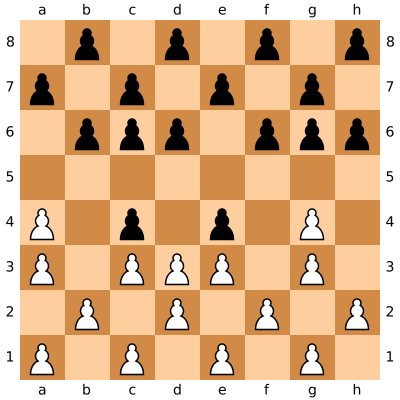

In [10]:
checkers = Checkers()
checkers.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
checkers.board

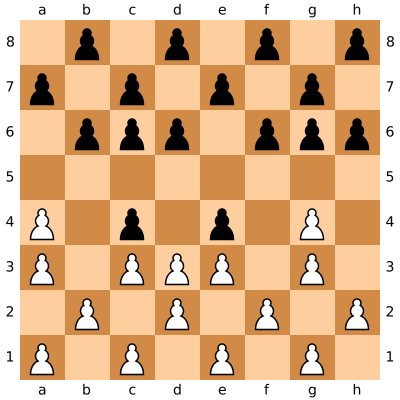

In [17]:
checkersLocal = Checkers()
checkersLocal.board = chess.Board("1p1p1p1p/p1p1p1p1/1ppp1ppp/8/P1p1p1P1/P1PPP1P1/1P1P1P1P/P1P1P1P1 b KQkq - 0 4")
checkersLocal.board